In [1]:
#TODO: a model trained on 24x24 to 192x192, check its performance
#write dataset that receive one tile video at 192x192



In [2]:
# import os
# import json
# import random
import numpy as np
import torchvision as tv
import torch as t
import time
import imp

import lib
# import lib_train
# import networks
import datasets
import networks

# import imp
imp.reload(networks)
imp.reload(lib)
imp.reload(datasets)
# imp.reload(lib_train)


<module 'datasets' from '/home/anh2/workspace/tile-super-resolution/datasets.py'>

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline


In [4]:
img_h0 = 192
img_w0 = 192
scale_factor = .125

target_mean_list, target_std_list = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
toImage = lib.ToImage(target_mean_list, target_std_list)
toVideo = lib.ToVideo(target_mean_list, target_std_list)

#input image size
img_h, img_w = int(img_h0 * scale_factor), int(img_w0 * scale_factor)


refimg_h, refimg_w = img_h, img_w #for now, reference patch has the same low resolution ias input image

In [7]:
root = './datasets/tiles'
#root = './datasets/davis'

SAMPLE_LENGTH = 3
NUM_WORKER_TRAINLOADER = 12
NUM_WORKER_TESTLOADER  = 1
BATCH_SIZE_TRAIN = 2

frame_lr_transform    = tv.transforms.Compose([tv.transforms.Resize((img_h, img_w))])#480, 864
frame_hr_transform = tv.transforms.Compose([tv.transforms.Resize((img_h0, img_w0))])#480, 864
refframe_transform = tv.transforms.Compose([tv.transforms.Resize((refimg_h, refimg_w))])#tv.transforms.Compose([lib.Resize(refframe_scale_factor), lib.ToTensor(), lib.Normalize(target_mean_list, target_std_list)])#480, 864
#vid_transform   = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
vid_transform   = tv.transforms.Compose([lib.ToTensor(), lib.Normalize(target_mean_list, target_std_list)])
trainset = datasets.InpaintDataset(root, mode = datasets.InpaintDataset.MODE_TRAIN, sample_length=SAMPLE_LENGTH, \
                                  frame_lr_transform=frame_lr_transform, frame_hr_transform=frame_hr_transform, vid_transform=vid_transform)
trainloader = t.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=NUM_WORKER_TRAINLOADER)


# testset = datasets.InpaintDataset(root, mode = datasets.InpaintDataset.MODE_TEST, sample_length=SAMPLE_LENGTH, \
#                                   frame_lr_transform=frame_lr_transform, frame_hr_transform=frame_hr_transform, vid_transform=vid_transform, refframe_transform=refframe_transform)
# testloader = t.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=NUM_WORKER_TESTLOADER)

In [8]:
len(trainloader)

110

In [9]:
%%capture

sr_path = './models/sr_epoch{}'

ngpu = 2
device = t.device("cuda:0" if (t.cuda.is_available() and ngpu > 0) else "cpu")
#device = t.device('cpu')
#iG = Generator(128)
stack_num = 8
hidden=128
sr = networks.SuperRes(hidden=hidden, stack_num=stack_num)
#iG.load_state_dict(t.load('./models/iG_epoch10')) #for unit test purpose only
sr.to(device)


In [10]:
beta1 = .5
optim = t.optim.Adam(sr.parameters(), lr=2e-4)


In [11]:
t_train_begin = time.time()

criterion = t.nn.MSELoss()

def loss_to_psnr(mse):
    psnr = 10 * np.log10(1 / mse)
    return psnr

def cal_psnr(pred, gt):
    mse = criterion(pred, gt)
    return loss_to_psnr(mse)

def infer(model, input, measurement=False):
    if measurement == False:
        return {'pred': model(input)}
    else:
        t.cuda.synchronize()
        since = int(round(time.time()*1000))        
        pred = sr(input)
        t.cuda.synchronize()
        time_elapsed = int(round(time.time()*1000)) - since     
        return {'pred': pred, 'time_elapsed': time_elapsed}

def show_train_images(plt, pred, frame_lr, frame_hr):
    img1 = toImage(pred)
    plt.imshow(img1)
    plt.figure()
    img2 = toImage(frame_lr)
    plt.imshow(img2)
    plt.figure()
    img3 = toImage(frame_hr)
    plt.imshow(img3)
    cal_psnr(pred, frame_hr)
    plt.figure()
    
import os


log_loss = []
log_psnr = []

In [13]:
btime = time.time()
for epoch in range(0, 20000):
    running_loss = 0.0
    running_psnr = 0.0
    for idx, ((frame_lr_list, frame_hr_list), frameidx_list) in enumerate(trainloader):
        #input frames has shape: BxTXCX
        frame_lr = frame_lr_list[:, 0, :, :, :].to(device)#only get the rist frame, not the whole video
        frame_hr = frame_hr_list[:, 0, :, :, :].to(device)
        
        optim.zero_grad()
        pred = infer(sr, frame_lr)['pred']
        loss = criterion(pred, frame_hr)
        loss.backward()
        optim.step()
        
        loss_item = loss.detach().item()
        running_loss += loss_item
        running_psnr += loss_to_psnr(loss_item)
    
        
        if (epoch * len(trainloader) + idx) % 1000 == 999:    # print every 2000 mini-batches
            report_time = (time.time( )- btime) * 1000
            btime = time.time()
            print('[time: %d (ms), epoch: %d, iteration: %2d] loss: %.4f, psnr: %.4f' %
                  (report_time * 1000, epoch + 1, idx + 1, loss_item, loss_to_psnr(loss_item)))
            running_loss = 0.0  
            running_psnr = 0.0
            log_psnr.append(loss_to_psnr(loss_item))
            log_loss.append(loss_item)
            
        if (epoch * len(trainloader) + idx) % 10000 == 3999:
            t.save(sr.state_dict(), sr_path.format(epoch))

[time: 24243691 (ms), epoch: 10, iteration: 10] loss: 0.0358, psnr: 14.4656
[time: 23710782 (ms), epoch: 19, iteration: 20] loss: 0.0494, psnr: 13.0620
[time: 23628383 (ms), epoch: 28, iteration: 30] loss: 0.0137, psnr: 18.6208
[time: 23897450 (ms), epoch: 37, iteration: 40] loss: 0.0055, psnr: 22.6242
[time: 24169834 (ms), epoch: 46, iteration: 50] loss: 0.0271, psnr: 15.6769
[time: 23977392 (ms), epoch: 55, iteration: 60] loss: 0.0049, psnr: 23.0929
[time: 23876836 (ms), epoch: 64, iteration: 70] loss: 0.0047, psnr: 23.2927
[time: 23986018 (ms), epoch: 73, iteration: 80] loss: 0.0392, psnr: 14.0704
[time: 24124745 (ms), epoch: 82, iteration: 90] loss: 0.0200, psnr: 16.9843
[time: 24079492 (ms), epoch: 91, iteration: 100] loss: 0.0112, psnr: 19.5270
[time: 24115483 (ms), epoch: 100, iteration: 110] loss: 0.0027, psnr: 25.7387
[time: 24789561 (ms), epoch: 110, iteration: 10] loss: 0.0028, psnr: 25.5207
[time: 23990412 (ms), epoch: 119, iteration: 20] loss: 0.0076, psnr: 21.1841
[time: 

[time: 23828687 (ms), epoch: 982, iteration: 90] loss: 0.0002, psnr: 36.4009
[time: 24152657 (ms), epoch: 991, iteration: 100] loss: 0.0083, psnr: 20.8301
[time: 23973452 (ms), epoch: 1000, iteration: 110] loss: 0.0120, psnr: 19.2247
[time: 24730313 (ms), epoch: 1010, iteration: 10] loss: 0.0053, psnr: 22.7179
[time: 24124697 (ms), epoch: 1019, iteration: 20] loss: 0.0060, psnr: 22.1880
[time: 24219028 (ms), epoch: 1028, iteration: 30] loss: 0.0011, psnr: 29.5028
[time: 24020962 (ms), epoch: 1037, iteration: 40] loss: 0.0052, psnr: 22.8398
[time: 24072444 (ms), epoch: 1046, iteration: 50] loss: 0.0308, psnr: 15.1119
[time: 23996727 (ms), epoch: 1055, iteration: 60] loss: 0.0002, psnr: 36.1271
[time: 23996196 (ms), epoch: 1064, iteration: 70] loss: 0.0029, psnr: 25.3940
[time: 24194104 (ms), epoch: 1073, iteration: 80] loss: 0.0213, psnr: 16.7247
[time: 23912334 (ms), epoch: 1082, iteration: 90] loss: 0.0171, psnr: 17.6792
[time: 24094777 (ms), epoch: 1091, iteration: 100] loss: 0.0026,

[time: 24036209 (ms), epoch: 1937, iteration: 40] loss: 0.0063, psnr: 22.0180
[time: 23979003 (ms), epoch: 1946, iteration: 50] loss: 0.0132, psnr: 18.7996
[time: 24120086 (ms), epoch: 1955, iteration: 60] loss: 0.0129, psnr: 18.8803
[time: 24137992 (ms), epoch: 1964, iteration: 70] loss: 0.0132, psnr: 18.7826
[time: 24130218 (ms), epoch: 1973, iteration: 80] loss: 0.0010, psnr: 29.8370
[time: 24019212 (ms), epoch: 1982, iteration: 90] loss: 0.0051, psnr: 22.9511
[time: 24206413 (ms), epoch: 1991, iteration: 100] loss: 0.0155, psnr: 18.0871
[time: 24073158 (ms), epoch: 2000, iteration: 110] loss: 0.0011, psnr: 29.6910
[time: 24787480 (ms), epoch: 2010, iteration: 10] loss: 0.0149, psnr: 18.2563
[time: 23960570 (ms), epoch: 2019, iteration: 20] loss: 0.0065, psnr: 21.8504
[time: 23996090 (ms), epoch: 2028, iteration: 30] loss: 0.0276, psnr: 15.5839
[time: 24106433 (ms), epoch: 2037, iteration: 40] loss: 0.0093, psnr: 20.3317
[time: 23933621 (ms), epoch: 2046, iteration: 50] loss: 0.0022

[time: 23956588 (ms), epoch: 2891, iteration: 100] loss: 0.0121, psnr: 19.1861
[time: 23986370 (ms), epoch: 2900, iteration: 110] loss: 0.0011, psnr: 29.5997
[time: 24774573 (ms), epoch: 2910, iteration: 10] loss: 0.0013, psnr: 28.6994
[time: 24232562 (ms), epoch: 2919, iteration: 20] loss: 0.0065, psnr: 21.8547
[time: 24121144 (ms), epoch: 2928, iteration: 30] loss: 0.0017, psnr: 27.7222
[time: 24160104 (ms), epoch: 2937, iteration: 40] loss: 0.0123, psnr: 19.1016
[time: 24087960 (ms), epoch: 2946, iteration: 50] loss: 0.0025, psnr: 25.9810
[time: 23999474 (ms), epoch: 2955, iteration: 60] loss: 0.0117, psnr: 19.3137
[time: 24208405 (ms), epoch: 2964, iteration: 70] loss: 0.0003, psnr: 34.8771
[time: 23988189 (ms), epoch: 2973, iteration: 80] loss: 0.0001, psnr: 38.5956
[time: 24138753 (ms), epoch: 2982, iteration: 90] loss: 0.0048, psnr: 23.1502
[time: 24098577 (ms), epoch: 2991, iteration: 100] loss: 0.0062, psnr: 22.0495
[time: 23925371 (ms), epoch: 3000, iteration: 110] loss: 0.00

[time: 24156536 (ms), epoch: 3846, iteration: 50] loss: 0.0003, psnr: 35.4769
[time: 24221316 (ms), epoch: 3855, iteration: 60] loss: 0.0033, psnr: 24.8508
[time: 24022403 (ms), epoch: 3864, iteration: 70] loss: 0.0010, psnr: 30.0439
[time: 23955369 (ms), epoch: 3873, iteration: 80] loss: 0.0032, psnr: 25.0079
[time: 24245975 (ms), epoch: 3882, iteration: 90] loss: 0.0129, psnr: 18.8895
[time: 23990355 (ms), epoch: 3891, iteration: 100] loss: 0.0099, psnr: 20.0433
[time: 24284434 (ms), epoch: 3900, iteration: 110] loss: 0.0018, psnr: 27.3591
[time: 24771013 (ms), epoch: 3910, iteration: 10] loss: 0.0011, psnr: 29.4469
[time: 24065556 (ms), epoch: 3919, iteration: 20] loss: 0.0073, psnr: 21.3700
[time: 24278911 (ms), epoch: 3928, iteration: 30] loss: 0.0066, psnr: 21.8086
[time: 23901193 (ms), epoch: 3937, iteration: 40] loss: 0.0042, psnr: 23.7519
[time: 24099016 (ms), epoch: 3946, iteration: 50] loss: 0.0060, psnr: 22.2463
[time: 24181238 (ms), epoch: 3955, iteration: 60] loss: 0.0019

[time: 24096399 (ms), epoch: 4800, iteration: 110] loss: 0.0025, psnr: 26.1051
[time: 24836214 (ms), epoch: 4810, iteration: 10] loss: 0.0008, psnr: 30.9649
[time: 24176227 (ms), epoch: 4819, iteration: 20] loss: 0.0065, psnr: 21.8439
[time: 24136254 (ms), epoch: 4828, iteration: 30] loss: 0.0044, psnr: 23.5555
[time: 24122437 (ms), epoch: 4837, iteration: 40] loss: 0.0015, psnr: 28.3788
[time: 24159325 (ms), epoch: 4846, iteration: 50] loss: 0.0131, psnr: 18.8417
[time: 24137172 (ms), epoch: 4855, iteration: 60] loss: 0.0097, psnr: 20.1193
[time: 24009520 (ms), epoch: 4864, iteration: 70] loss: 0.0008, psnr: 30.7396
[time: 24064078 (ms), epoch: 4873, iteration: 80] loss: 0.0002, psnr: 37.0088
[time: 24207999 (ms), epoch: 4882, iteration: 90] loss: 0.0036, psnr: 24.3862
[time: 23999299 (ms), epoch: 4891, iteration: 100] loss: 0.0012, psnr: 29.1230
[time: 24230228 (ms), epoch: 4900, iteration: 110] loss: 0.0056, psnr: 22.5458
[time: 24850854 (ms), epoch: 4910, iteration: 10] loss: 0.000

[time: 24078200 (ms), epoch: 5755, iteration: 60] loss: 0.0017, psnr: 27.6836
[time: 24112947 (ms), epoch: 5764, iteration: 70] loss: 0.0039, psnr: 24.0917
[time: 24008683 (ms), epoch: 5773, iteration: 80] loss: 0.0003, psnr: 34.8373
[time: 24167402 (ms), epoch: 5782, iteration: 90] loss: 0.0005, psnr: 32.7498
[time: 24150447 (ms), epoch: 5791, iteration: 100] loss: 0.0054, psnr: 22.6818
[time: 23970495 (ms), epoch: 5800, iteration: 110] loss: 0.0013, psnr: 29.0055
[time: 24681259 (ms), epoch: 5810, iteration: 10] loss: 0.0014, psnr: 28.4283
[time: 24166353 (ms), epoch: 5819, iteration: 20] loss: 0.0052, psnr: 22.8691
[time: 24338133 (ms), epoch: 5828, iteration: 30] loss: 0.0136, psnr: 18.6713
[time: 24028514 (ms), epoch: 5837, iteration: 40] loss: 0.0013, psnr: 28.8769
[time: 24008919 (ms), epoch: 5846, iteration: 50] loss: 0.0009, psnr: 30.2440
[time: 24093765 (ms), epoch: 5855, iteration: 60] loss: 0.0089, psnr: 20.5098
[time: 23954687 (ms), epoch: 5864, iteration: 70] loss: 0.0040

[time: 24784541 (ms), epoch: 6710, iteration: 10] loss: 0.0060, psnr: 22.1914
[time: 24027932 (ms), epoch: 6719, iteration: 20] loss: 0.0041, psnr: 23.8433
[time: 24176178 (ms), epoch: 6728, iteration: 30] loss: 0.0034, psnr: 24.6627
[time: 24197765 (ms), epoch: 6737, iteration: 40] loss: 0.0016, psnr: 27.8844
[time: 24076490 (ms), epoch: 6746, iteration: 50] loss: 0.0015, psnr: 28.2821
[time: 24227321 (ms), epoch: 6755, iteration: 60] loss: 0.0011, psnr: 29.6804
[time: 24204708 (ms), epoch: 6764, iteration: 70] loss: 0.0010, psnr: 30.0675
[time: 24152605 (ms), epoch: 6773, iteration: 80] loss: 0.0010, psnr: 29.9926
[time: 23913898 (ms), epoch: 6782, iteration: 90] loss: 0.0026, psnr: 25.9176
[time: 24308284 (ms), epoch: 6791, iteration: 100] loss: 0.0018, psnr: 27.4696
[time: 23950426 (ms), epoch: 6800, iteration: 110] loss: 0.0079, psnr: 21.0220
[time: 24730401 (ms), epoch: 6810, iteration: 10] loss: 0.0117, psnr: 19.3033
[time: 23971058 (ms), epoch: 6819, iteration: 20] loss: 0.0050

[time: 24105902 (ms), epoch: 7664, iteration: 70] loss: 0.0046, psnr: 23.3924
[time: 23936420 (ms), epoch: 7673, iteration: 80] loss: 0.0043, psnr: 23.6535
[time: 24046952 (ms), epoch: 7682, iteration: 90] loss: 0.0045, psnr: 23.5076
[time: 24039735 (ms), epoch: 7691, iteration: 100] loss: 0.0001, psnr: 40.8796
[time: 23948605 (ms), epoch: 7700, iteration: 110] loss: 0.0039, psnr: 24.1211
[time: 24798597 (ms), epoch: 7710, iteration: 10] loss: 0.0010, psnr: 29.8245
[time: 24216367 (ms), epoch: 7719, iteration: 20] loss: 0.0004, psnr: 33.8430
[time: 24003425 (ms), epoch: 7728, iteration: 30] loss: 0.0057, psnr: 22.4323
[time: 23997795 (ms), epoch: 7737, iteration: 40] loss: 0.0057, psnr: 22.4107
[time: 24044274 (ms), epoch: 7746, iteration: 50] loss: 0.0019, psnr: 27.3079
[time: 24091195 (ms), epoch: 7755, iteration: 60] loss: 0.0132, psnr: 18.7984
[time: 24190842 (ms), epoch: 7764, iteration: 70] loss: 0.0006, psnr: 32.4378
[time: 23958919 (ms), epoch: 7773, iteration: 80] loss: 0.0081

[time: 24040765 (ms), epoch: 8619, iteration: 20] loss: 0.0011, psnr: 29.5525
[time: 24275421 (ms), epoch: 8628, iteration: 30] loss: 0.0027, psnr: 25.7125
[time: 24139024 (ms), epoch: 8637, iteration: 40] loss: 0.0002, psnr: 37.0696
[time: 24086049 (ms), epoch: 8646, iteration: 50] loss: 0.0010, psnr: 30.0599
[time: 24070733 (ms), epoch: 8655, iteration: 60] loss: 0.0001, psnr: 38.3629
[time: 24151473 (ms), epoch: 8664, iteration: 70] loss: 0.0099, psnr: 20.0644
[time: 24194885 (ms), epoch: 8673, iteration: 80] loss: 0.0004, psnr: 34.4561
[time: 24001642 (ms), epoch: 8682, iteration: 90] loss: 0.0070, psnr: 21.5732
[time: 24161659 (ms), epoch: 8691, iteration: 100] loss: 0.0074, psnr: 21.3205
[time: 24085700 (ms), epoch: 8700, iteration: 110] loss: 0.0041, psnr: 23.9081
[time: 24788632 (ms), epoch: 8710, iteration: 10] loss: 0.0069, psnr: 21.6139
[time: 24104841 (ms), epoch: 8719, iteration: 20] loss: 0.0001, psnr: 38.9570
[time: 24146696 (ms), epoch: 8728, iteration: 30] loss: 0.0003

[time: 24037154 (ms), epoch: 9573, iteration: 80] loss: 0.0110, psnr: 19.5984
[time: 24208408 (ms), epoch: 9582, iteration: 90] loss: 0.0077, psnr: 21.1503
[time: 24050089 (ms), epoch: 9591, iteration: 100] loss: 0.0074, psnr: 21.2883
[time: 24224554 (ms), epoch: 9600, iteration: 110] loss: 0.0023, psnr: 26.3093
[time: 24669729 (ms), epoch: 9610, iteration: 10] loss: 0.0050, psnr: 22.9790
[time: 23977708 (ms), epoch: 9619, iteration: 20] loss: 0.0068, psnr: 21.6572
[time: 24109571 (ms), epoch: 9628, iteration: 30] loss: 0.0172, psnr: 17.6426
[time: 24145188 (ms), epoch: 9637, iteration: 40] loss: 0.0028, psnr: 25.5513
[time: 24051179 (ms), epoch: 9646, iteration: 50] loss: 0.0021, psnr: 26.8133
[time: 24249593 (ms), epoch: 9655, iteration: 60] loss: 0.0042, psnr: 23.7449
[time: 24148557 (ms), epoch: 9664, iteration: 70] loss: 0.0018, psnr: 27.4333
[time: 24925667 (ms), epoch: 9673, iteration: 80] loss: 0.0005, psnr: 32.9082
[time: 24544264 (ms), epoch: 9682, iteration: 90] loss: 0.0003

[time: 24099995 (ms), epoch: 10528, iteration: 30] loss: 0.0024, psnr: 26.2156
[time: 23856961 (ms), epoch: 10537, iteration: 40] loss: 0.0055, psnr: 22.5902
[time: 24158772 (ms), epoch: 10546, iteration: 50] loss: 0.0054, psnr: 22.6674
[time: 23976887 (ms), epoch: 10555, iteration: 60] loss: 0.0013, psnr: 28.8259
[time: 24129298 (ms), epoch: 10564, iteration: 70] loss: 0.0030, psnr: 25.2177
[time: 24102953 (ms), epoch: 10573, iteration: 80] loss: 0.0024, psnr: 26.1302
[time: 24193831 (ms), epoch: 10582, iteration: 90] loss: 0.0012, psnr: 29.2582
[time: 24190154 (ms), epoch: 10591, iteration: 100] loss: 0.0035, psnr: 24.5432
[time: 24249994 (ms), epoch: 10600, iteration: 110] loss: 0.0047, psnr: 23.2473
[time: 24865664 (ms), epoch: 10610, iteration: 10] loss: 0.0051, psnr: 22.9551
[time: 24130710 (ms), epoch: 10619, iteration: 20] loss: 0.0085, psnr: 20.6928
[time: 24200278 (ms), epoch: 10628, iteration: 30] loss: 0.0009, psnr: 30.5330
[time: 24045957 (ms), epoch: 10637, iteration: 40]

[time: 24161342 (ms), epoch: 11473, iteration: 80] loss: 0.0001, psnr: 41.5085
[time: 24201364 (ms), epoch: 11482, iteration: 90] loss: 0.0012, psnr: 29.0654
[time: 24055185 (ms), epoch: 11491, iteration: 100] loss: 0.0042, psnr: 23.7807
[time: 24190549 (ms), epoch: 11500, iteration: 110] loss: 0.0051, psnr: 22.9508
[time: 24816283 (ms), epoch: 11510, iteration: 10] loss: 0.0067, psnr: 21.7465
[time: 24112925 (ms), epoch: 11519, iteration: 20] loss: 0.0005, psnr: 32.8863
[time: 24251276 (ms), epoch: 11528, iteration: 30] loss: 0.0021, psnr: 26.8570
[time: 24285385 (ms), epoch: 11537, iteration: 40] loss: 0.0015, psnr: 28.2116
[time: 24314104 (ms), epoch: 11546, iteration: 50] loss: 0.0052, psnr: 22.8368
[time: 24214607 (ms), epoch: 11555, iteration: 60] loss: 0.0115, psnr: 19.4065
[time: 24199873 (ms), epoch: 11564, iteration: 70] loss: 0.0008, psnr: 30.8218
[time: 24267453 (ms), epoch: 11573, iteration: 80] loss: 0.0074, psnr: 21.2802
[time: 24144893 (ms), epoch: 11582, iteration: 90]

[time: 24089406 (ms), epoch: 12419, iteration: 20] loss: 0.0033, psnr: 24.8473
[time: 24436600 (ms), epoch: 12428, iteration: 30] loss: 0.0052, psnr: 22.8412
[time: 24078955 (ms), epoch: 12437, iteration: 40] loss: 0.0031, psnr: 25.1479
[time: 24270055 (ms), epoch: 12446, iteration: 50] loss: 0.0008, psnr: 30.7385
[time: 24211267 (ms), epoch: 12455, iteration: 60] loss: 0.0071, psnr: 21.4830
[time: 24131628 (ms), epoch: 12464, iteration: 70] loss: 0.0008, psnr: 31.0043
[time: 24246778 (ms), epoch: 12473, iteration: 80] loss: 0.0048, psnr: 23.1625
[time: 24225651 (ms), epoch: 12482, iteration: 90] loss: 0.0073, psnr: 21.3790
[time: 24235463 (ms), epoch: 12491, iteration: 100] loss: 0.0007, psnr: 31.8555
[time: 24313307 (ms), epoch: 12500, iteration: 110] loss: 0.0018, psnr: 27.3460
[time: 24785941 (ms), epoch: 12510, iteration: 10] loss: 0.0004, psnr: 33.7494
[time: 24102050 (ms), epoch: 12519, iteration: 20] loss: 0.0022, psnr: 26.6130
[time: 24109542 (ms), epoch: 12528, iteration: 30]

[time: 24018338 (ms), epoch: 13364, iteration: 70] loss: 0.0053, psnr: 22.7667
[time: 24160340 (ms), epoch: 13373, iteration: 80] loss: 0.0152, psnr: 18.1899
[time: 24057679 (ms), epoch: 13382, iteration: 90] loss: 0.0082, psnr: 20.8598
[time: 24524116 (ms), epoch: 13391, iteration: 100] loss: 0.0076, psnr: 21.1853
[time: 24059271 (ms), epoch: 13400, iteration: 110] loss: 0.0048, psnr: 23.2038
[time: 24844861 (ms), epoch: 13410, iteration: 10] loss: 0.0010, psnr: 30.0752
[time: 24122064 (ms), epoch: 13419, iteration: 20] loss: 0.0006, psnr: 32.5553
[time: 23973869 (ms), epoch: 13428, iteration: 30] loss: 0.0080, psnr: 20.9949
[time: 24183922 (ms), epoch: 13437, iteration: 40] loss: 0.0048, psnr: 23.2298
[time: 24024518 (ms), epoch: 13446, iteration: 50] loss: 0.0014, psnr: 28.5771
[time: 24163403 (ms), epoch: 13455, iteration: 60] loss: 0.0050, psnr: 23.0393
[time: 24099725 (ms), epoch: 13464, iteration: 70] loss: 0.0013, psnr: 29.0284
[time: 24186256 (ms), epoch: 13473, iteration: 80]

[time: 24746633 (ms), epoch: 14310, iteration: 10] loss: 0.0047, psnr: 23.3003
[time: 24137828 (ms), epoch: 14319, iteration: 20] loss: 0.0026, psnr: 25.9158
[time: 24211583 (ms), epoch: 14328, iteration: 30] loss: 0.0034, psnr: 24.6790
[time: 24036198 (ms), epoch: 14337, iteration: 40] loss: 0.0052, psnr: 22.8550
[time: 24280738 (ms), epoch: 14346, iteration: 50] loss: 0.0003, psnr: 35.3170
[time: 24004277 (ms), epoch: 14355, iteration: 60] loss: 0.0016, psnr: 27.8755
[time: 24162940 (ms), epoch: 14364, iteration: 70] loss: 0.0036, psnr: 24.4323
[time: 24102725 (ms), epoch: 14373, iteration: 80] loss: 0.0016, psnr: 28.0677
[time: 24113356 (ms), epoch: 14382, iteration: 90] loss: 0.0115, psnr: 19.3838
[time: 24163931 (ms), epoch: 14391, iteration: 100] loss: 0.0016, psnr: 28.0279
[time: 23980153 (ms), epoch: 14400, iteration: 110] loss: 0.0080, psnr: 20.9637
[time: 24844379 (ms), epoch: 14410, iteration: 10] loss: 0.0057, psnr: 22.4640
[time: 24029627 (ms), epoch: 14419, iteration: 20]

[time: 24167818 (ms), epoch: 15255, iteration: 60] loss: 0.0005, psnr: 32.6964
[time: 24076923 (ms), epoch: 15264, iteration: 70] loss: 0.0065, psnr: 21.8882
[time: 24232600 (ms), epoch: 15273, iteration: 80] loss: 0.0033, psnr: 24.7632
[time: 24057666 (ms), epoch: 15282, iteration: 90] loss: 0.0005, psnr: 32.8091
[time: 24128925 (ms), epoch: 15291, iteration: 100] loss: 0.0020, psnr: 26.9195
[time: 24144304 (ms), epoch: 15300, iteration: 110] loss: 0.0014, psnr: 28.5825
[time: 24899387 (ms), epoch: 15310, iteration: 10] loss: 0.0063, psnr: 22.0046
[time: 24162476 (ms), epoch: 15319, iteration: 20] loss: 0.0100, psnr: 20.0063
[time: 24122823 (ms), epoch: 15328, iteration: 30] loss: 0.0006, psnr: 32.1587
[time: 24189146 (ms), epoch: 15337, iteration: 40] loss: 0.0021, psnr: 26.7255
[time: 24000193 (ms), epoch: 15346, iteration: 50] loss: 0.0088, psnr: 20.5422
[time: 24212044 (ms), epoch: 15355, iteration: 60] loss: 0.0048, psnr: 23.2031
[time: 24023030 (ms), epoch: 15364, iteration: 70]

[time: 24268826 (ms), epoch: 16200, iteration: 110] loss: 0.0037, psnr: 24.2934
[time: 24739418 (ms), epoch: 16210, iteration: 10] loss: 0.0022, psnr: 26.6210
[time: 24129745 (ms), epoch: 16219, iteration: 20] loss: 0.0033, psnr: 24.8050
[time: 24115900 (ms), epoch: 16228, iteration: 30] loss: 0.0011, psnr: 29.5376
[time: 24084007 (ms), epoch: 16237, iteration: 40] loss: 0.0001, psnr: 39.0426
[time: 24203361 (ms), epoch: 16246, iteration: 50] loss: 0.0014, psnr: 28.4010
[time: 24170323 (ms), epoch: 16255, iteration: 60] loss: 0.0005, psnr: 33.3070
[time: 24160946 (ms), epoch: 16264, iteration: 70] loss: 0.0009, psnr: 30.7021
[time: 24087190 (ms), epoch: 16273, iteration: 80] loss: 0.0032, psnr: 24.9830
[time: 24144101 (ms), epoch: 16282, iteration: 90] loss: 0.0007, psnr: 31.6854
[time: 24192149 (ms), epoch: 16291, iteration: 100] loss: 0.0029, psnr: 25.3965
[time: 24099206 (ms), epoch: 16300, iteration: 110] loss: 0.0046, psnr: 23.3398
[time: 24893359 (ms), epoch: 16310, iteration: 10

[time: 24082802 (ms), epoch: 17146, iteration: 50] loss: 0.0000, psnr: 43.4743
[time: 24220560 (ms), epoch: 17155, iteration: 60] loss: 0.0027, psnr: 25.6678
[time: 24083224 (ms), epoch: 17164, iteration: 70] loss: 0.0007, psnr: 31.5694
[time: 24108062 (ms), epoch: 17173, iteration: 80] loss: 0.0043, psnr: 23.6556
[time: 24184953 (ms), epoch: 17182, iteration: 90] loss: 0.0026, psnr: 25.7773
[time: 24031100 (ms), epoch: 17191, iteration: 100] loss: 0.0018, psnr: 27.3677
[time: 24014289 (ms), epoch: 17200, iteration: 110] loss: 0.0011, psnr: 29.6015
[time: 25337234 (ms), epoch: 17210, iteration: 10] loss: 0.0054, psnr: 22.6402
[time: 24854120 (ms), epoch: 17219, iteration: 20] loss: 0.0083, psnr: 20.7861
[time: 24588629 (ms), epoch: 17228, iteration: 30] loss: 0.0012, psnr: 29.2913
[time: 24981924 (ms), epoch: 17237, iteration: 40] loss: 0.0042, psnr: 23.8177
[time: 24792148 (ms), epoch: 17246, iteration: 50] loss: 0.0012, psnr: 29.3638
[time: 24812059 (ms), epoch: 17255, iteration: 60]

[time: 24135477 (ms), epoch: 18091, iteration: 100] loss: 0.0111, psnr: 19.5644
[time: 24203656 (ms), epoch: 18100, iteration: 110] loss: 0.0026, psnr: 25.8357
[time: 24780386 (ms), epoch: 18110, iteration: 10] loss: 0.0075, psnr: 21.2225
[time: 24096368 (ms), epoch: 18119, iteration: 20] loss: 0.0075, psnr: 21.2432
[time: 24168797 (ms), epoch: 18128, iteration: 30] loss: 0.0034, psnr: 24.7194
[time: 24628866 (ms), epoch: 18137, iteration: 40] loss: 0.0025, psnr: 26.0913
[time: 24041892 (ms), epoch: 18146, iteration: 50] loss: 0.0002, psnr: 37.6303
[time: 24193669 (ms), epoch: 18155, iteration: 60] loss: 0.0006, psnr: 31.9254
[time: 24114884 (ms), epoch: 18164, iteration: 70] loss: 0.0071, psnr: 21.4611
[time: 24192153 (ms), epoch: 18173, iteration: 80] loss: 0.0060, psnr: 22.2506
[time: 24227129 (ms), epoch: 18182, iteration: 90] loss: 0.0054, psnr: 22.6881
[time: 24033619 (ms), epoch: 18191, iteration: 100] loss: 0.0034, psnr: 24.6877
[time: 24182046 (ms), epoch: 18200, iteration: 11

[time: 24008328 (ms), epoch: 19037, iteration: 40] loss: 0.0044, psnr: 23.5648
[time: 24195037 (ms), epoch: 19046, iteration: 50] loss: 0.0010, psnr: 30.1572
[time: 24208399 (ms), epoch: 19055, iteration: 60] loss: 0.0016, psnr: 28.0644
[time: 24167520 (ms), epoch: 19064, iteration: 70] loss: 0.0003, psnr: 35.2625
[time: 24223819 (ms), epoch: 19073, iteration: 80] loss: 0.0038, psnr: 24.2583
[time: 24166592 (ms), epoch: 19082, iteration: 90] loss: 0.0070, psnr: 21.5192
[time: 24154068 (ms), epoch: 19091, iteration: 100] loss: 0.0039, psnr: 24.1008
[time: 24282317 (ms), epoch: 19100, iteration: 110] loss: 0.0073, psnr: 21.3699
[time: 24769843 (ms), epoch: 19110, iteration: 10] loss: 0.0002, psnr: 37.3635
[time: 24163014 (ms), epoch: 19119, iteration: 20] loss: 0.0019, psnr: 27.1278
[time: 24108375 (ms), epoch: 19128, iteration: 30] loss: 0.0041, psnr: 23.9220
[time: 24449466 (ms), epoch: 19137, iteration: 40] loss: 0.0002, psnr: 37.5389
[time: 24363457 (ms), epoch: 19146, iteration: 50]

[time: 24354787 (ms), epoch: 19982, iteration: 90] loss: 0.0015, psnr: 28.3568
[time: 24062876 (ms), epoch: 19991, iteration: 100] loss: 0.0052, psnr: 22.8009
[time: 24130792 (ms), epoch: 20000, iteration: 110] loss: 0.0009, psnr: 30.6956


In [ ]:
t.save(sr..state_dict(), sr_path.format(epoch))

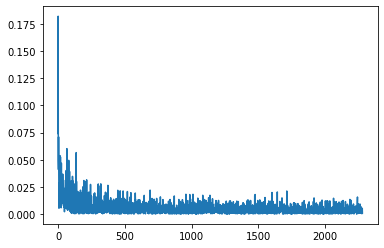

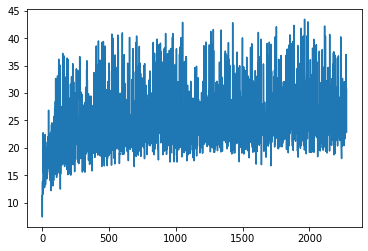

In [14]:
plt.plot(log_loss)
plt.figure()
plt.plot(log_psnr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8745) tensor(-1.)
tensor(29.8288)
tensor(-0.1059) tensor(-0.7882)
tensor(20.1014)
tensor(0.0275) tensor(-0.7804)
tensor(34.2141)
tensor(1.) tensor(-1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/anh2/anaconda2/envs/env_pytorch_python3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/anh2/anaconda2/envs/env_pytorch_python3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/anh2/anaconda2/envs/env_pytorch_pyth

tensor(29.5257)
tensor(1.) tensor(-1.)
tensor(27.6015)
tensor(0.2314) tensor(-0.8980)
tensor(20.2041)
tensor(0.9922) tensor(-0.6627)
tensor(23.3698)
tensor(0.8824) tensor(-1.)
tensor(19.8760)
tensor(0.1137) tensor(-1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(16.7681)
tensor(0.2706) tensor(-0.9529)
tensor(22.0604)
tensor(0.8902) tensor(-0.9294)
tensor(24.1861)
tensor(0.1294) tensor(-1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(22.7385)
tensor(0.8353) tensor(-0.5765)
tensor(24.8882)
tensor(0.1843) tensor(-0.6627)
tensor(36.9521)
tensor(-0.1294) tensor(-0.9608)
tensor(21.6293)
tensor(0.6941) tensor(-0.7020)
tensor(33.8483)
tensor(0.8667) tensor(-1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(16.4760)
tensor(0.8039) tensor(-0.7020)
tensor(35.8548)
tensor(1.) tensor(-0.7490)
tensor(28.9133)
tensor(-0.0118) tensor(-1.)
tensor(23.1664)
tensor(0.0275) tensor(-1.)
tensor(22.5987)
tensor(-0.2863) tensor(-1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(30.2875)
tensor(0.8824) tensor(-0.8745)
tensor(20.4558)
tensor(0.0667) tensor(-0.9608)
tensor(16.6836)
tensor(0.1529) tensor(-0.7647)
tensor(35.8455)
tensor(0.8980) tensor(-1.)
tensor(25.5937)
tensor(0.1529) tensor(-1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(29.8260)
tensor(0.9216) tensor(-0.7020)
tensor(22.7414)
tensor(0.0196) tensor(-0.7020)
tensor(35.2169)
tensor(1.) tensor(-0.6863)
tensor(39.1008)
tensor(0.7490) tensor(-0.8745)
tensor(36.3309)
tensor(0.3490) tensor(-1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(26.9127)
tensor(0.7804) tensor(-0.9451)
tensor(22.8501)
tensor(0.5059) tensor(-1.)
tensor(30.5040)
tensor(0.9843) tensor(-0.7647)
tensor(23.7753)
tensor(0.5216) tensor(-0.9529)
tensor(33.4587)
tensor(0.9451) tensor(-0.6627)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(27.3756)
tensor(0.8745) tensor(-0.6784)
tensor(27.4628)
tensor(0.4980) tensor(-0.7647)
tensor(21.6867)
tensor(0.8431) tensor(-0.9216)
tensor(24.7181)
tensor(0.9686) tensor(-0.7020)
tensor(22.3225)
tensor(0.5922) tensor(-0.8667)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(22.1834)
tensor(0.0510) tensor(-0.8196)
tensor(24.3688)
tensor(0.0039) tensor(-1.)
tensor(22.3444)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8039) tensor(-1.)
tensor(36.6366)
tensor(0.1686) tensor(-0.8824)
tensor(32.7264)
tensor(-0.0824) tensor(-0.9686)
tensor(21.0505)
tensor(0.8431) tensor(-0.7961)
tensor(21.8849)
tensor(1.) tensor(-0.6627)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(20.4481)
tensor(0.9608) tensor(-1.)
tensor(28.9246)
tensor(0.0275) tensor(-0.7098)
tensor(18.5894)
tensor(0.8039) tensor(-1.)
tensor(27.8929)
tensor(0.0745) tensor(-0.8824)
tensor(28.8123)
tensor(0.6627) tensor(-0.6941)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(37.7106)
tensor(1.) tensor(-0.8118)
tensor(28.2167)
tensor(0.9059) tensor(-0.7961)
tensor(27.6401)
tensor(0.2941) tensor(-0.9059)
tensor(21.1158)
tensor(0.8353) tensor(-0.6078)
tensor(28.4695)
tensor(0.9608) tensor(-1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(35.7776)
tensor(0.9922) tensor(-0.7569)
tensor(30.1537)
tensor(0.8039) tensor(-0.6706)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(19.2913)
tensor(0.8510) tensor(-0.6000)
tensor(26.7532)
tensor(0.0353) tensor(-0.7647)
tensor(34.5231)
tensor(0.9922) tensor(-0.9765)
tensor(21.1659)
tensor(1.) tensor(-0.8118)
tensor(23.4647)
tensor(0.7647) tensor(-1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(29.2107)
tensor(0.4118) tensor(-0.9059)
tensor(19.6336)
tensor(0.9608) tensor(-0.8745)
tensor(18.3795)
tensor(0.9843) tensor(-1.)
tensor(29.7376)
tensor(0.5922) tensor(-0.8431)
tensor(36.2757)
tensor(0.3804) tensor(-1.)
tensor(36.6152)
tensor(0.7098) tensor(-0.9059)
tensor(34.3738)
tensor(0.4353) tensor(-0.9765)
tensor(36.4184)
tensor(-0.0039) tensor(-1.)


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fee47dcf560> (for post_execute):


KeyboardInterrupt: 

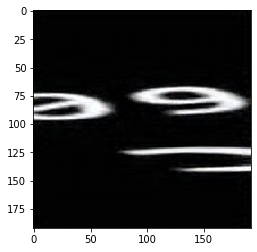

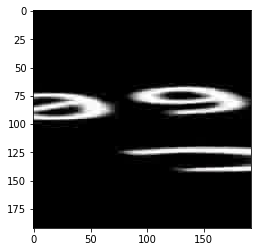

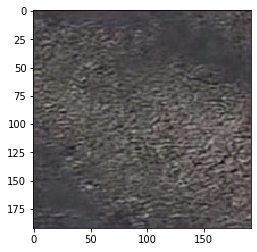

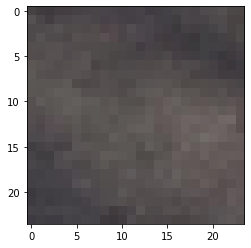

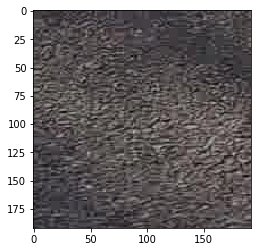

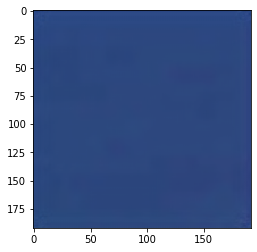

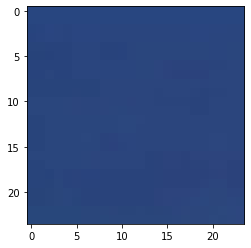

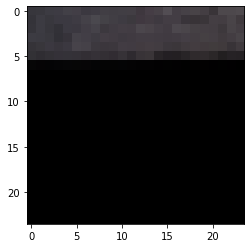

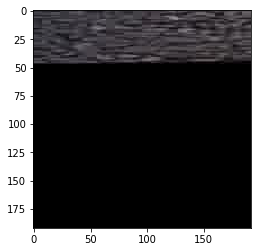

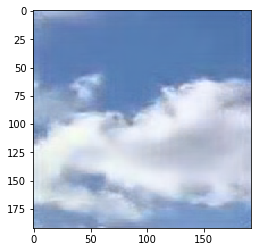

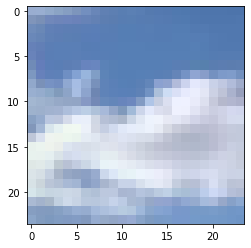

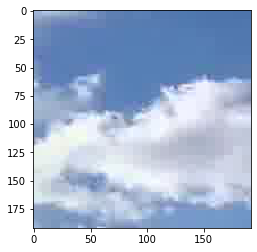

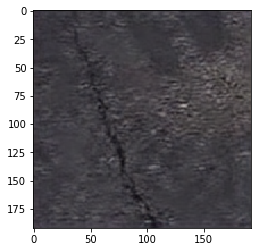

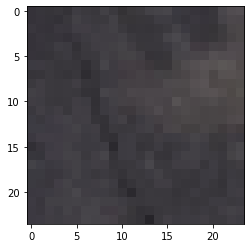

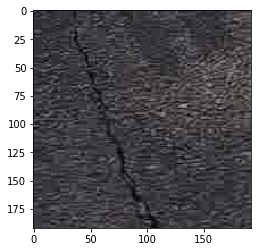

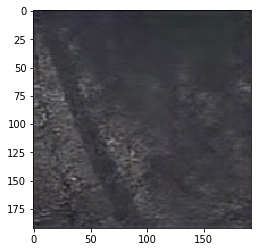

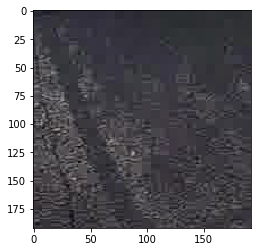

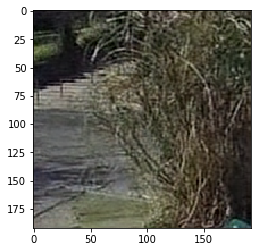

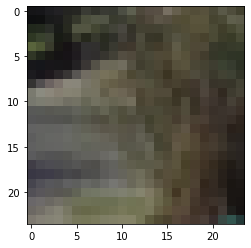

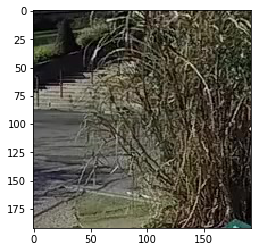

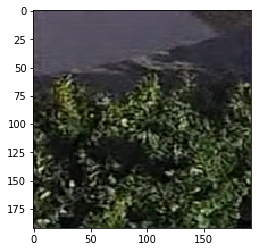

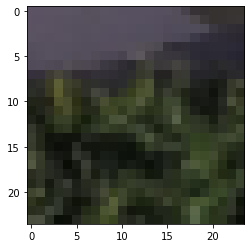

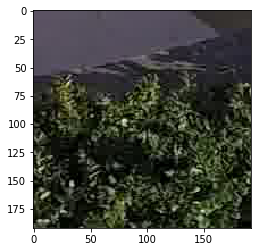

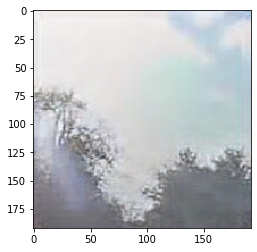

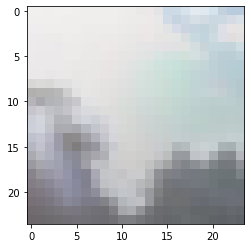

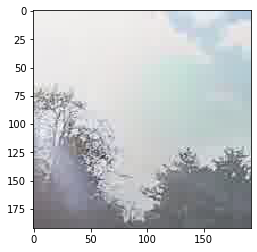

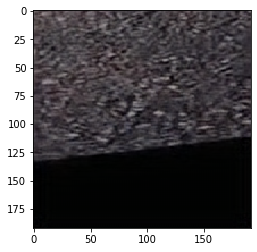

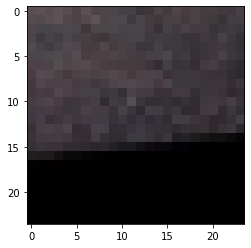

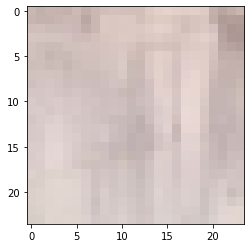

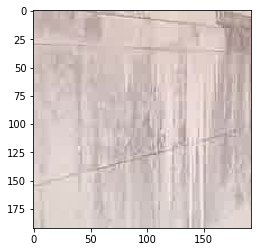

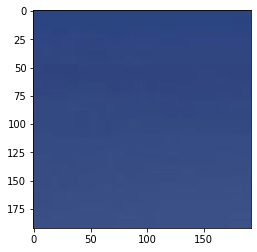

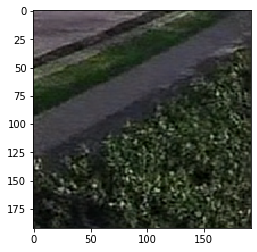

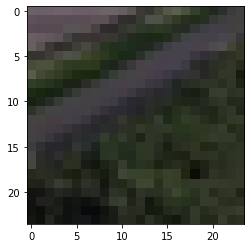

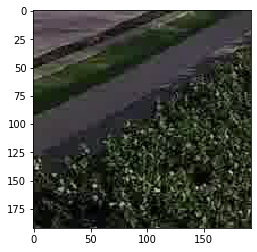

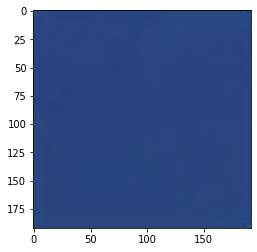

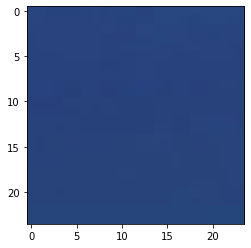

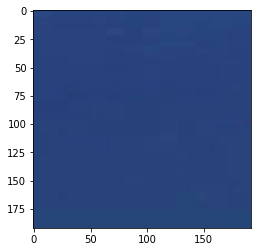

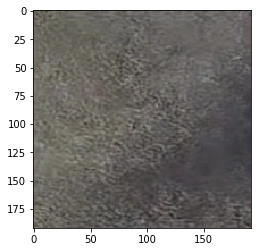

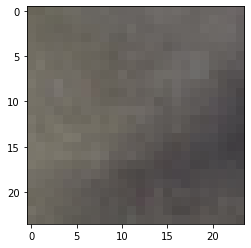

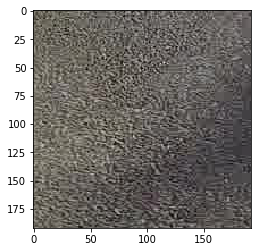

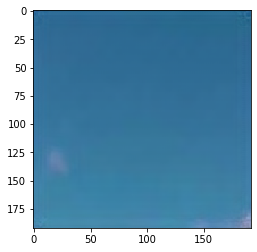

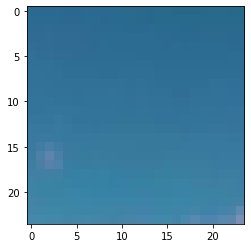

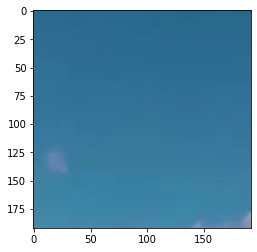

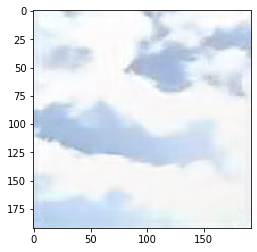

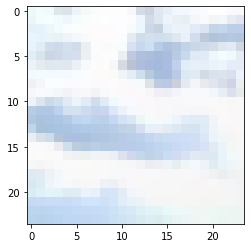

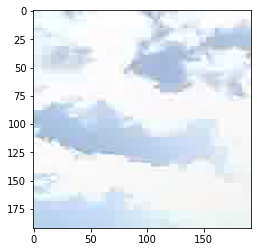

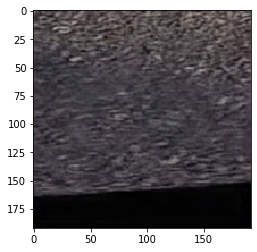

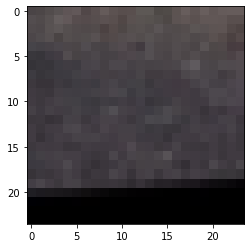

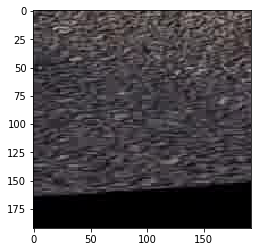

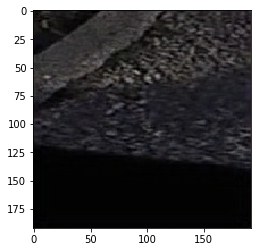

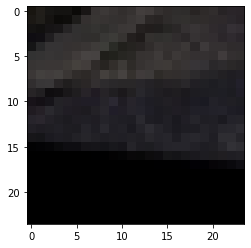

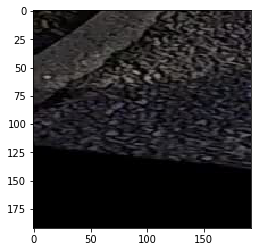

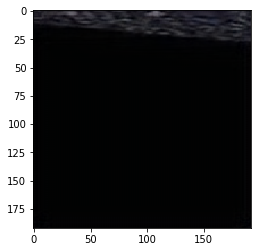

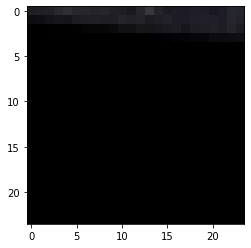

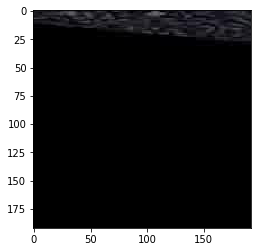

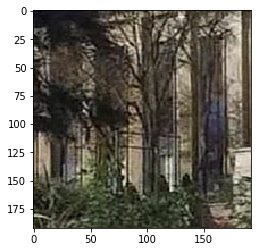

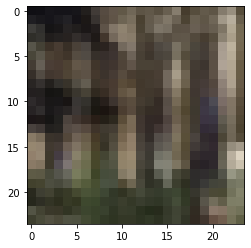

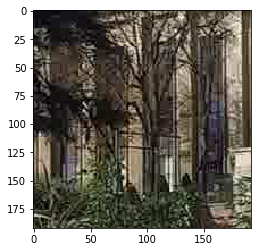

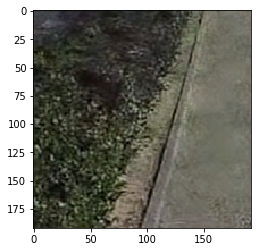

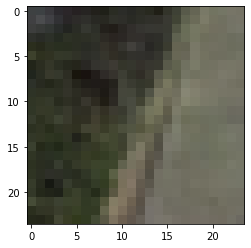

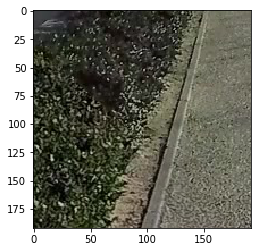

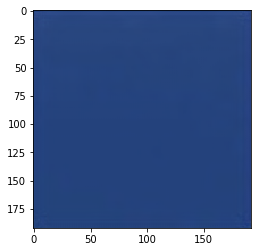

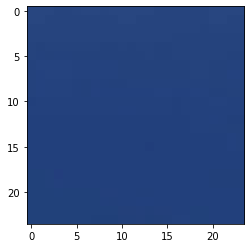

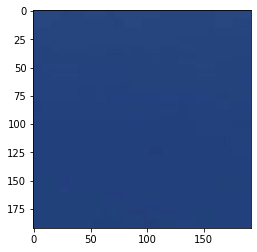

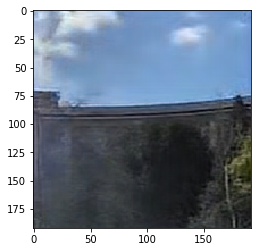

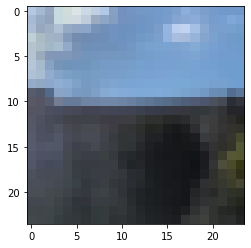

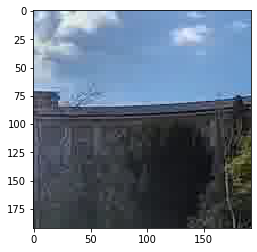

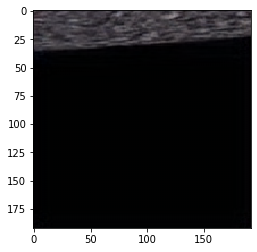

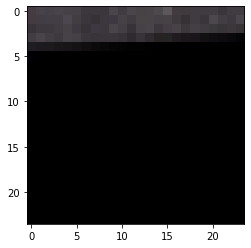

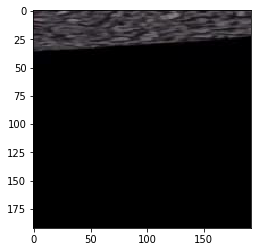

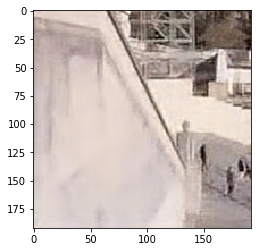

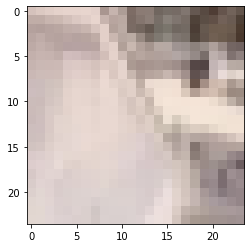

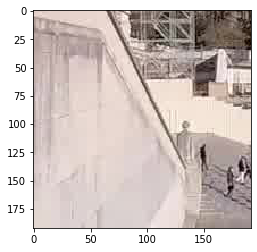

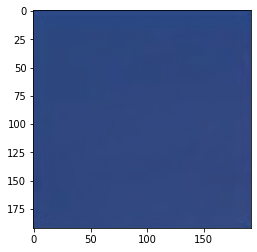

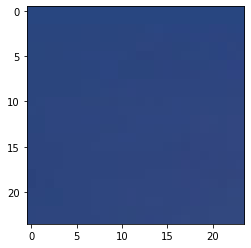

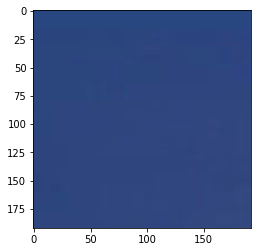

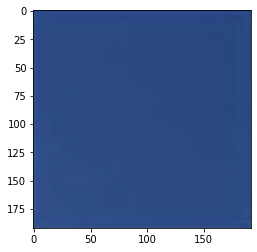

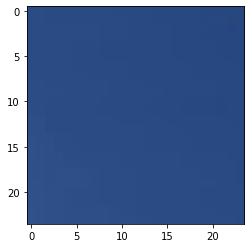

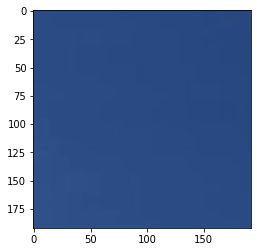

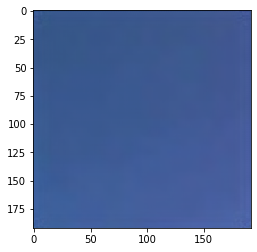

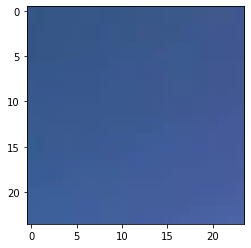

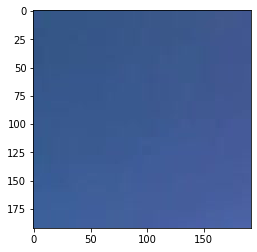

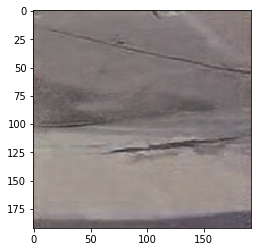

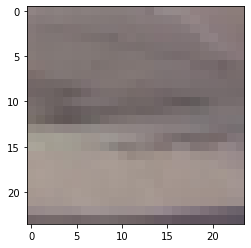

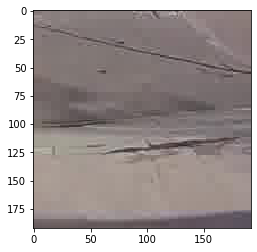

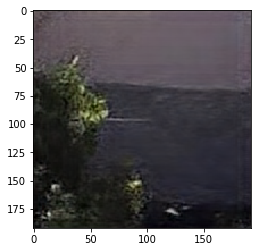

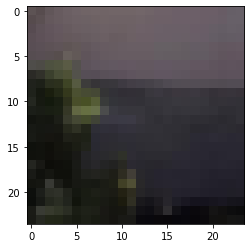

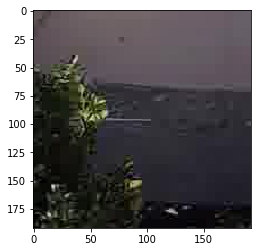

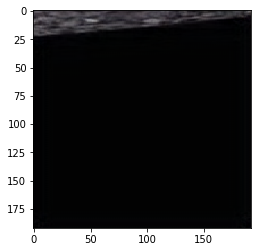

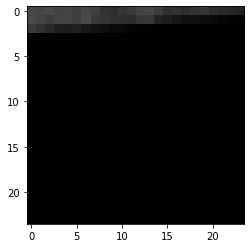

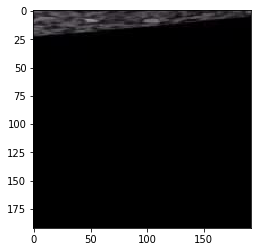

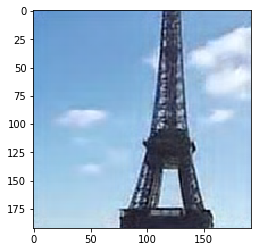

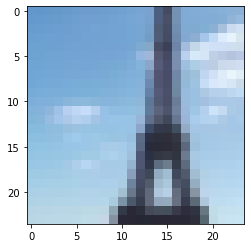

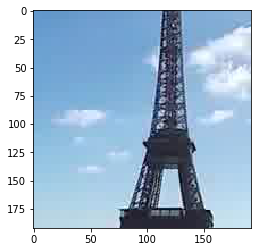

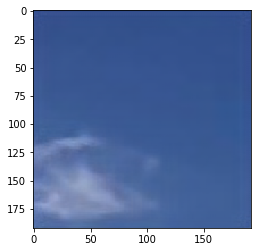

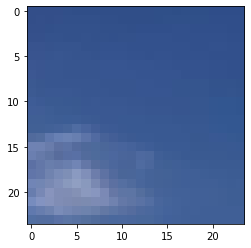

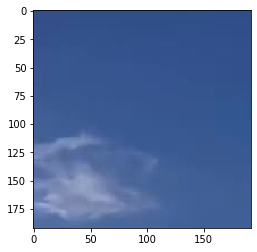

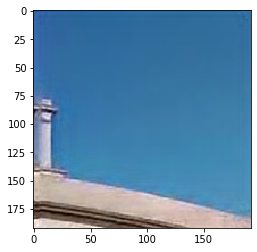

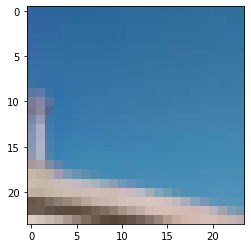

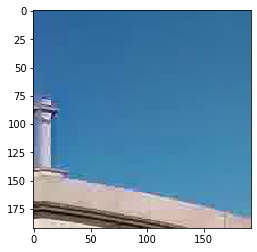

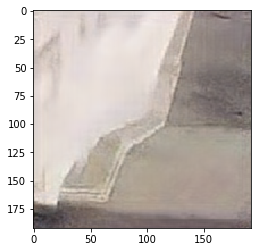

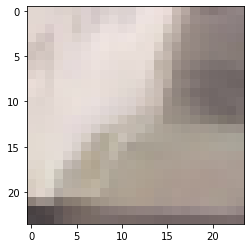

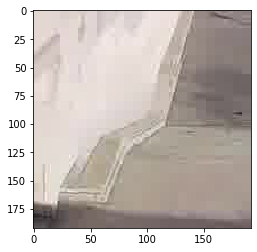

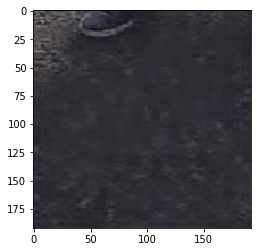

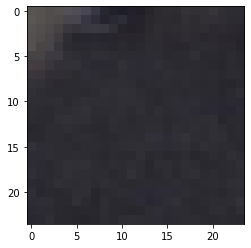

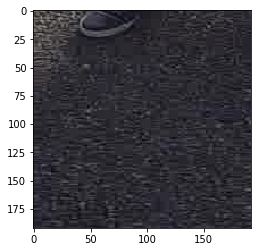

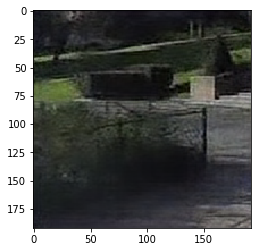

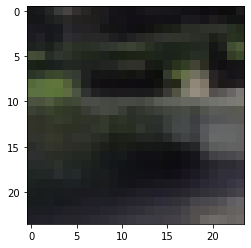

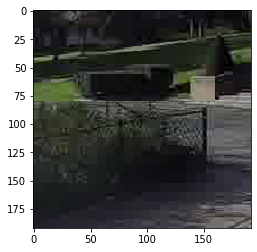

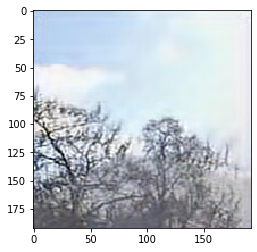

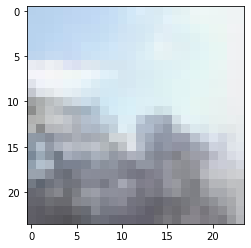

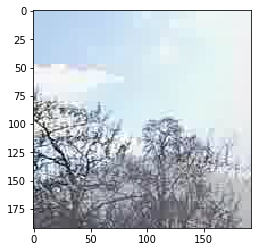

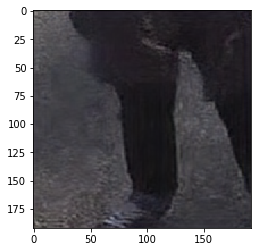

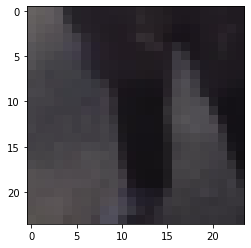

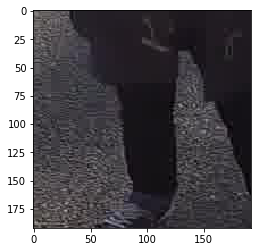

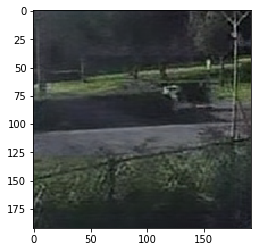

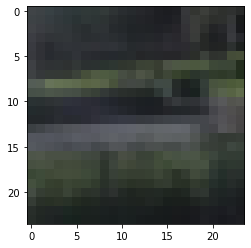

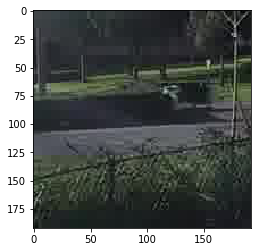

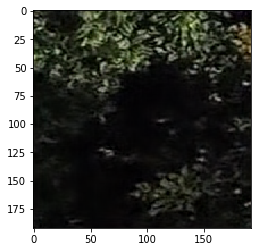

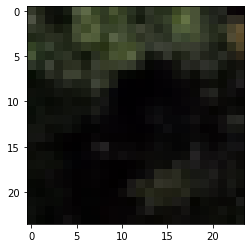

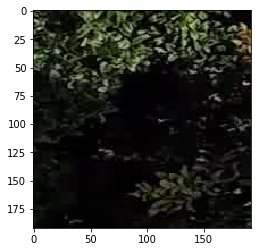

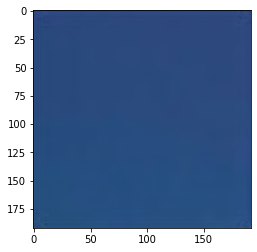

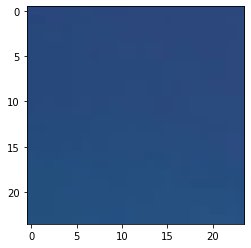

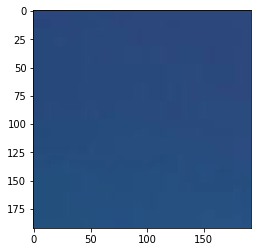

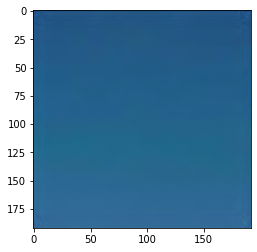

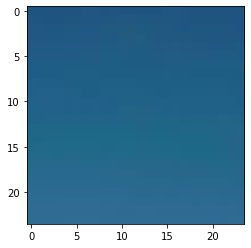

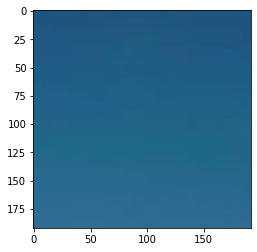

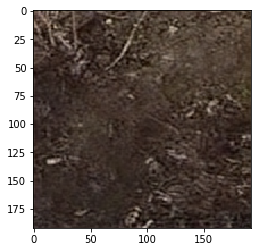

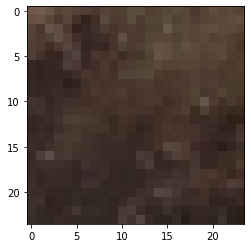

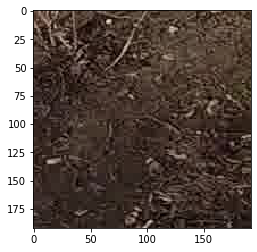

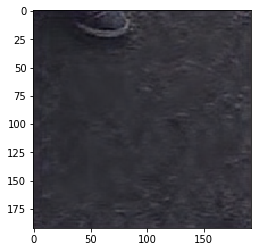

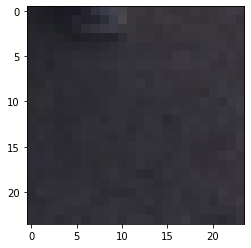

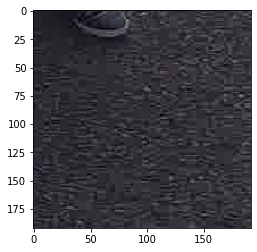

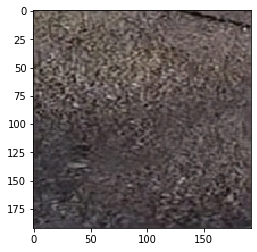

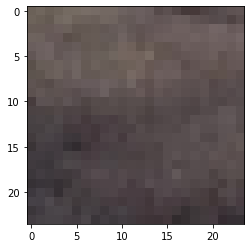

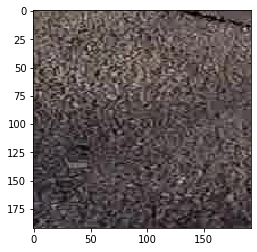

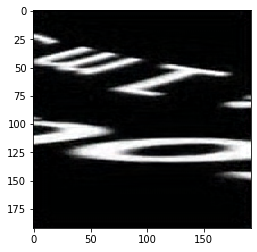

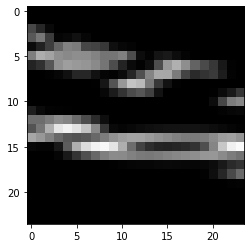

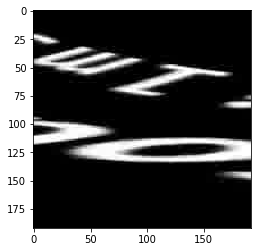

Error in callback <function flush_figures at 0x7fee47ddbf80> (for post_execute):


KeyboardInterrupt: 

In [15]:
for idx, ((frame_lr_list, frame_hr_list), frameidx_list) in enumerate(trainloader):
    frame_lr = frame_lr_list[:, 0, :, :, :].to(device)#only get the rist frame, not the whole video
    frame_hr = frame_hr_list[:, 0, :, :, :].to(device)   
    with t.no_grad():
        pred = infer(sr, frame_lr)['pred']
    
    print (frame_lr_list.max(), frame_lr_list.min())
    show_train_images(plt, pred[0].detach().cpu(), frame_lr_list[0][0].detach().cpu(), frame_hr_list[0][0].detach().cpu())
    print (cal_psnr(pred[0].detach().cpu(), frame_hr_list[0][0].detach().cpu()))
    
    if idx > 10: 
        break

In [25]:
for idx, ((frame_lr_list, frame_hr_list), frameidx_list) in enumerate(trainloader):
    frame_lr = frame_lr_list[:, 0, :, :, :].to(device)#only get the rist frame, not the whole video
    frame_hr = frame_hr_list[:, 0, :, :, :].to(device)   
    with t.no_grad():
        print (infer(sr, frame_lr, measurement=True)['time_elapsed'])

5
4
3


In [18]:
sorted(trainset.videoname_list)

['paris_8_1_0_0',
 'paris_8_1_0_1152',
 'paris_8_1_0_1344',
 'paris_8_1_0_1536',
 'paris_8_1_0_1728',
 'paris_8_1_0_192',
 'paris_8_1_0_1920',
 'paris_8_1_0_384',
 'paris_8_1_0_576',
 'paris_8_1_0_768',
 'paris_8_1_0_960',
 'paris_8_1_1152_0',
 'paris_8_1_1152_1152',
 'paris_8_1_1152_1344',
 'paris_8_1_1152_1536',
 'paris_8_1_1152_1728',
 'paris_8_1_1152_192',
 'paris_8_1_1152_1920',
 'paris_8_1_1152_384',
 'paris_8_1_1152_576',
 'paris_8_1_1152_768',
 'paris_8_1_1152_960',
 'paris_8_1_1344_0',
 'paris_8_1_1344_1152',
 'paris_8_1_1344_1344',
 'paris_8_1_1344_1536',
 'paris_8_1_1344_1728',
 'paris_8_1_1344_192',
 'paris_8_1_1344_1920',
 'paris_8_1_1344_384',
 'paris_8_1_1344_576',
 'paris_8_1_1344_768',
 'paris_8_1_1344_960',
 'paris_8_1_1536_0',
 'paris_8_1_1536_1152',
 'paris_8_1_1536_1344',
 'paris_8_1_1536_1536',
 'paris_8_1_1536_1728',
 'paris_8_1_1536_192',
 'paris_8_1_1536_1920',
 'paris_8_1_1536_384',
 'paris_8_1_1536_576',
 'paris_8_1_1536_768',
 'paris_8_1_1536_960',
 'paris_8